In [1]:
from utils import (
    sig,
    sigfit,
    adj_rmse,
    TwoFlashesProcessingStrategy,
    TwoFlashesProcessingStrategy_Explore,
)

## Experimental Data

In [3]:
import pandas as pd

# Load data
df = pd.read_csv("DFI_SPQ_Data.csv")
data = pd.melt(df, value_name="Flashes", var_name="Delay", id_vars=["ID", "Group"])
data["Flashes"] = (data["Flashes"] / 10) * 100

# Average data by group
avg_data = data.groupby(["Group", "Delay"])["Flashes"].aggregate(["mean"])
avg_data.reset_index(inplace=True)
avg_data.rename(columns={"mean": "Flashes (%)"}, inplace=True)
avg_data["Delay"] = avg_data.Delay.astype(float)

# Fit group data to sigmoid
for group in avg_data.groupby("Group"):
    if group[0] == "H-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=14.6033, b=61.7941, c=86.2012, d=-27.569
        )
        df_hspq = group[1]
    elif group[0] == "L-SPQ":
        group[1]["Fit"] = sig(
            x=group[1]["Delay"], a=15.045, b=66.7106, c=59.806, d=-26.553
        )
        df_lspq = group[1]

dataset = pd.concat([df_hspq, df_lspq])
dataset.head()

## TODO double check fit values

,Group,Delay,Flashes (%),Fit
0,H-SPQ,108.0,35.357143,33.884199
1,H-SPQ,120.0,30.357143,28.623599
2,H-SPQ,132.0,27.142857,24.465345
3,H-SPQ,144.0,18.928571,21.365804
4,H-SPQ,156.0,18.214286,19.155035


<Axes: xlabel='Delay', ylabel='Flashes (%)'>

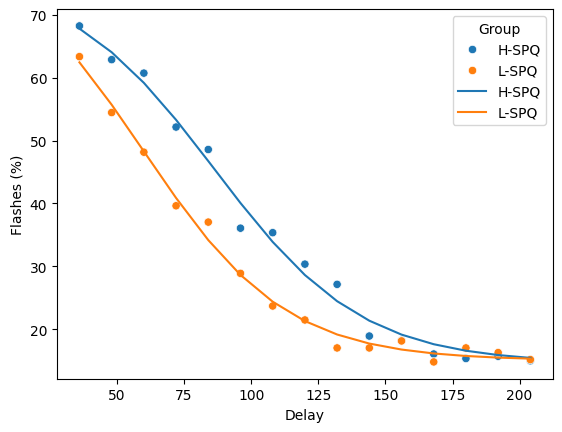

In [4]:
import seaborn as sns

sns.scatterplot(data=dataset, x="Delay", y="Flashes (%)", hue="Group")
sns.lineplot(data=dataset, x="Delay", y="Fit", hue="Group")

<Axes: xlabel='Delay', ylabel='Fit'>

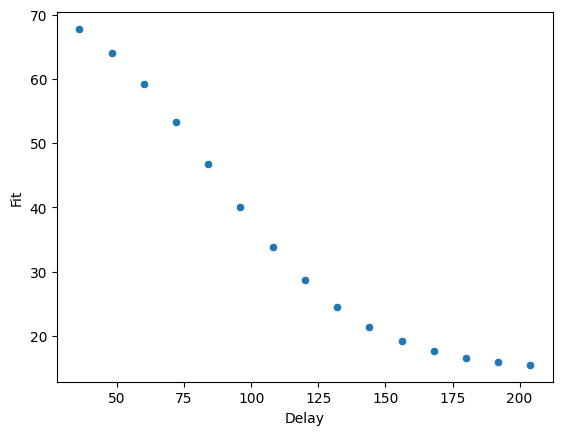

In [10]:
# Data to fit
hspq_data = dataset.query("Group == 'H-SPQ'").sort_values(by=["Delay"])["Fit"].values
soas = dataset.query("Group == 'H-SPQ'").sort_values(by=["Delay"])["Delay"].values
sns.scatterplot(data=dataset.query("Group == 'H-SPQ'"), y="Fit", x="Delay")

## Fitting

In [43]:
from skneuromsi.neural import Paredes2022
from skneuromsi.sweep import ParameterSweep
from scipy.optimize import differential_evolution
import multiprocess as mp
import numpy as np


def two_flashes_job(l_ex):

    model = Paredes2022(
        time_range=(0, 500),
        neurons=30,
        position_range=(0, 30),
        tau=(6.560e00, 9.191e00, 1.200e02),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=1,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=l_ex,
        lateral_inhibition=0.4,
        cross_modal_weight=1.036e-03,
        feedback_weight=6.231e-01,
        feedforward_weight=3.892e00,
    )

    return res


def hspq_cost(theta):

    exp_data = hspq_data
    model_data = two_flashes_job(l_ex=theta[0])
    cost = np.sum(np.square(np.divide(exp_data - model_data, exp_data)))

    return cost


bounds = [(0.4, 0.65)]

with mp.Pool(12) as pool:
    hspq_fit_res = differential_evolution(
        hspq_cost,
        bounds,
        disp=True,
        updating="deferred",
        workers=pool.map,
        polish=False,
    )

differential_evolution step 1: f(x)= 0.0704338121142149
differential_evolution step 2: f(x)= 0.0704338121142149
differential_evolution step 3: f(x)= 0.0704338121142149
differential_evolution step 4: f(x)= 0.0704338121142149
differential_evolution step 5: f(x)= 0.06867631832815843
differential_evolution step 6: f(x)= 0.06859303362724788
differential_evolution step 7: f(x)= 0.06832514173554805
differential_evolution step 8: f(x)= 0.06832514173554805


In [44]:
print(hspq_fit_res)

             message: Optimization terminated successfully.
             success: True
                 fun: 0.06832514173554805
                   x: [ 5.305e-01]
                 nit: 8
                nfev: 135
          population: [[ 5.305e-01]
                       [ 5.304e-01]
                       ...
                       [ 5.323e-01]
                       [ 5.304e-01]]
 population_energies: [ 6.833e-02  6.834e-02 ...  7.055e-02  6.853e-02]


## Exploration

In [ ]:
from skneuromsi.neural import Paredes2022
from skneuromsi.sweep import ParameterSweep
from scipy.optimize import differential_evolution
import multiprocess as mp
import numpy as np


def two_flashes_job(l_ex):

    model = Paredes2022(
        time_range=(0, 500),
        neurons=30,
        position_range=(0, 30),
        tau=(6.560e00, 9.191e00, 1.200e02),
    )

    sp = ParameterSweep(
        model=model,
        target="auditory_soa",
        repeat=1,
        n_jobs=10,
        range=soas,
        processing_strategy=TwoFlashesProcessingStrategy_Explore(),
    )

    res = sp.run(
        auditory_intensity=2.325,
        visual_intensity=1.45,
        auditory_stim_n=2,
        visual_stim_n=1,
        auditory_duration=7,
        visual_duration=12,
        noise=False,
        lateral_excitation=l_ex,
        lateral_inhibition=0.4,
        cross_modal_weight=1.036e-03,
        feedback_weight=6.231e-01,
        feedforward_weight=3.892e00,
    )

    return res


results_list, two_flashes_res, _ = two_flashes_job(l_ex=5.305e-01)

Sweeping 'auditory_soa':   0%|          | 0/15 [00:00<?, ?it/s]

In [51]:
sig_soas = np.linspace(soas[0], soas[-1], endpoint=True, num=100)
a, b, c, d = sigfit(soas, two_flashes_res)
print(a, b, c, d)
fb_model_data = sig(sig_soas, a, b, c, d)

17.06861268238607 45.44622258279948 98.65069937031683 -15.255320769267612


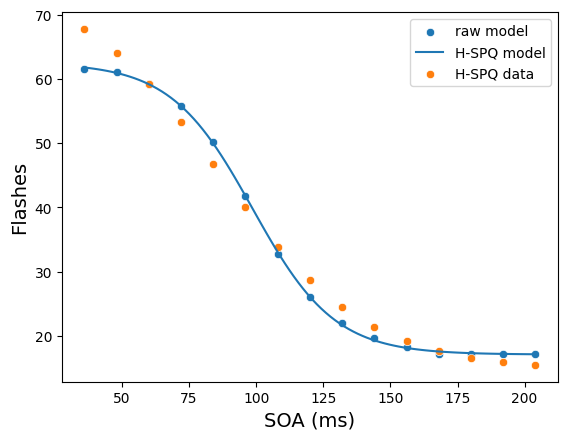

In [52]:
import matplotlib.pyplot as plt

sns.scatterplot(x=soas, y=two_flashes_res, label="raw model")
sns.lineplot(x=sig_soas, y=fb_model_data, label="H-SPQ model")
sns.scatterplot(
    data=dataset.query("Group == 'H-SPQ'"), y="Fit", x="Delay", label="H-SPQ data"
)
plt.ylabel("Flashes", size=14)
plt.xlabel("SOA (ms)", size=14)
plt.show()

In [53]:
scz_error = adj_rmse(two_flashes_res, dataset.query("Group == 'H-SPQ'").Fit.values, 1)
print(scz_error)

32.781133872466995
